# DM rates scorecards

## Get packages and JPMaQS data

This notebook serves as an illustration of the power of macro indicators in fixed income markets. 

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package, `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [47]:
import pandas as pd
from datetime import date
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.visuals as msv
from macrosynergy.management.utils import merge_categories

from sklearn.metrics import (
    make_scorer,
    r2_score,
)

from macrosynergy.download import JPMaQSDownload
from macrosynergy.visuals import ScoreVisualisers

pd.set_option('display.width', 400)
import warnings

warnings.simplefilter("ignore")

In [2]:
cids_g2 = ['USD', 'EUR']
cids_oth = ["AUD", "CAD", "CHF", "GBP", "JPY", "SEK"]
cids_dm = cids_g2 + cids_oth
cids_ea = ["DEM", "FRF", "ESP", "ITL"]  
cids = cids_dm + cids_ea

In [3]:
# Category tickers

π = [
    "CPIH_SA_P1M1ML12",
    "CPIC_SA_P1M1ML12",
    "INFE1Y_JA",
    "INFTEFF_NSA",
    "INFTEFF_NSA",
    "CPICE_SJA_P3M3ML3AR",
    "CPIC_SJA_P3M3ML3AR",
]
gdp = [
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "RGDPTECHv5Y_SA_P1M1ML12_3MMA",
    "RGDP_SA_P1Q1QL4_20QMM",
    "USDGDPWGT_SA_3YMA"
]
cons = ["RPCONS_SA_P1Q1QL4", "XRPCONS_SA_P1Q1QL4", "RPCONS_SA_P1M1ML12"]
credit = ["PCREDITBN_SJA_P1M1ML12"]
wages = ["WAGES_NSA_P1M1ML12", "WAGES_NSA_P1M1ML12_3MMA", "WAGES_NSA_P1Q1QL4"]
labour = [
    "UNEMPLRATE_SA_3MMA",
    "EMPL_NSA_P1M1ML12_3MMA",
    "EMPL_NSA_P1Q1QL4",
    "UNEMPLRATE_SA_3MMAv5YMA",
    "WFORCE_NSA_P1Y1YL1_5YMM",
]
gov_b = ["GGOBGDPRATIO_NSA", "IMPORTS_SA_P6M6ML6AR"]
bor_reqs = ["GNBRGDP_NSA_12MMA"]
rir = ["RIR_NSA", "RYLDIRS05Y_NSA"]
scores = [
    "MBCSCORE_SA_3MMA",
    "CCSCORE_SA",
    "CCSCORE_SA_3MMA",
    "SBCSCORE_SA_3MMA",
    "CBCSCORE_SA_3MMA",
    "SBCSCORE_SA",
]

macro = π + gdp + wages + scores
fiscal = bor_reqs + gov_b
price = rir
vol = cons + credit + labour

main = fiscal + macro + price + vol

# Target returns

rets = ["DU05YXR_NSA"]

# Tickers

xcats = main + rets

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 420


In [4]:
# Download series from J.P. Morgan DataQuery by tickers

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date="2000-01-01",
        suppress_warning=True,
        metrics=[
            "value",
        ],
        show_progress=True,
    )

Timestamp UTC:  2025-02-25 10:29:52
Connection successful!


Requesting data: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
129 out of 408 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.


In [5]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()
dfx_rets = dfx[dfx['xcat'].isin(rets)]

<class 'pandas.core.frame.DataFrame'>
Index: 1777595 entries, 32414 to 1698881
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 67.8+ MB


## Preparatory calculations, labelling and normalization (scoring)

### Euro area proxies

The following cell fills in the inflation expectation, credit, real yield and unemployment indicators for the primary Eurozone currencies [‘DEM’, ‘ESP’, ‘FRF’, ‘ITL’]. Essentially, it duplicates the EUR values and assigns them to their respective currencies.


In [6]:
cids_ea = ["DEM", "FRF", "ESP", "ITL"]
cidx = cids_ea
xcatx = [
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
    "UNEMPLRATE_SA_3MMA",
    "UNEMPLRATE_SA_3MMAv5YMA",
    "INFTEFF_NSA",
    "INFTEFF_NSA",
    "INFE1Y_JA",
    "CPIC_SJA_P3M3ML3AR"
]

calcs = [f"{xc}=  iEUR_{xc}" for xc in xcatx]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

We also calculate borrowing requirement trends for EUR as an average between Italy, Spain and German borrowing requirements. We don't have monthly French borrowing requirements.

In [7]:
cid = ["EUR"]
xcatx = ["GNBRGDP_NSA_12MMA"]

calcs = [
    "GNBRGDP_NSA_12MMA = ( iITL_GNBRGDP_NSA_12MMA + iESP_GNBRGDP_NSA_12MMA + iDEM_GNBRGDP_NSA_12MMA ) / 3",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cid)
dfx = msm.update_df(dfx, dfa)

In [8]:
# Combining early and regular short-term core inflation
new_df = merge_categories(dfx, ['CPICE_SJA_P3M3ML3AR','CPIC_SJA_P3M3ML3AR'] , 'CPICC_SJA_P3M3ML3AR', cids)
dfx = msm.update_df(dfx, new_df).reset_index(drop=True)

In [9]:
dict_repl = {
    "RPCONS_SA_P1M1ML12": "RPCONS_SA_P1Q1QL4",
    "EMPL_NSA_P1Q1QL4" : "EMPL_NSA_P1M1ML12_3MMA",
    "WAGES_NSA_P1Q1QL4" : "WAGES_NSA_P1M1ML12_3MMA",
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

# Avoiding duplicate entries by only running replacement for specific countries
cidx = ['AUD', 'JPY', 'GBP']

dict_repl = {
"SBCSCORE_SA": "SBCSCORE_SA_3MMA"   
}

for key, value in dict_repl.items():
    dfx.loc[dfx['cid'].isin(cidx), 'xcat'] = dfx.loc[dfx['cid'].isin(cidx), 'xcat'].str.replace(key, value)

cidx = ['CHF']

dict_repl = {
 "CCSCORE_SA": "CCSCORE_SA_3MMA"
}

for key, value in dict_repl.items():
    dfx.loc[dfx['cid'].isin(cidx), 'xcat'] = dfx.loc[dfx['cid'].isin(cidx), 'xcat'].str.replace(key, value)



### Composite categories calculation

In [10]:
cidx = cids

calcs = [
    "XCPIH_SA_P1M1ML12 = CPIH_SA_P1M1ML12 - INFTEFF_NSA ", # excess headline inflation
    "XCPIC_SA_P1M1ML12 = CPIC_SA_P1M1ML12 - INFTEFF_NSA ", # excess core inflation
    "XCPICC_SJA_P3M3ML3AR = CPICC_SJA_P3M3ML3AR - INFTEFF_NSA ", # excess core short term inflation
    "XINFE1Y_JA = INFE1Y_JA - INFTEFF_NSA ", # excess expected inflation
    "XRPCONS_SA_P1Q1QL4 = RPCONS_SA_P1Q1QL4 - RGDP_SA_P1Q1QL4_20QMM ", # excess real private consumption
    "XEMPL_NSA_P1M1ML12_3MMA = EMPL_NSA_P1M1ML12_3MMA - WFORCE_NSA_P1Y1YL1_5YMM",  # relative to workforce growth
    "LPGT = RGDP_SA_P1Q1QL4_20QMM - WFORCE_NSA_P1Y1YL1_5YMM ",  # labor productivity growth trend, building the Excess wage growth
    "XGGOBGDPRATIO_NSA = GGOBGDPRATIO_NSA + 3 ", # Excess overall balance
    "XIMPORTS_SA_P6M6ML6AR = IMPORTS_SA_P6M6ML6AR - INFTEFF_NSA - RGDP_SA_P1Q1QL4_20QMM", # Exces import growth
    "XWAGES_NSA_P1M1ML12_3MMA = WAGES_NSA_P1M1ML12_3MMA - LPGT - INFTEFF_NSA ", # Excess wage growth
    "XGNBRGDP_NSA_12MMA = GNBRGDP_NSA_12MMA - 3", # excess net borrowing requirements
    "XPCREDITBN_SJA_P1M1ML12 = PCREDITBN_SJA_P1M1ML12 - INFTEFF_NSA - RGDP_SA_P1Q1QL4_20QMM" # excess private bank credit
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

In [11]:
cidx = cids
xcatx = π
# Making categories negative when they have a positive impact on returns
calcs = [
    "XCPIC_SA_P1M1ML12_NEG = XCPIC_SA_P1M1ML12 * (-1) ", 
    "XCPIH_SA_P1M1ML12_NEG = XCPIH_SA_P1M1ML12 * (-1) ",
    "XCPICC_SJA_P3M3ML3AR_NEG = XCPICC_SJA_P3M3ML3AR * (-1) ",
    "XINFE1Y_JA_NEG = XINFE1Y_JA * (-1) ",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA_NEG = INTRGDPv5Y_NSA_P1M1ML12_3MMA * (-1) ",
    "RGDPTECHv5Y_SA_P1M1ML12_3MMA_NEG = RGDPTECHv5Y_SA_P1M1ML12_3MMA * (-1) ",
    "XRPCONS_SA_P1Q1QL4_NEG = XRPCONS_SA_P1Q1QL4 * (-1) ",
    "XIMPORTS_SA_P6M6ML6AR_NEG = XIMPORTS_SA_P6M6ML6AR * (-1) ",
    "MBCSCORE_SA_3MMA_NEG = MBCSCORE_SA_3MMA * (-1) ",
    "CCSCORE_SA_3MMA_NEG = CCSCORE_SA_3MMA * (-1) ",
    "SBCSCORE_SA_3MMA_NEG = SBCSCORE_SA_3MMA * (-1) ",
    "CBCSCORE_SA_3MMA_NEG = CBCSCORE_SA_3MMA * (-1) ",
    "XEMPL_NSA_P1M1ML12_3MMA_NEG = XEMPL_NSA_P1M1ML12_3MMA * (-1) ",
    "XWAGES_NSA_P1M1ML12_3MMA_NEG = XWAGES_NSA_P1M1ML12_3MMA * (-1) ",
    "XPCREDITBN_SJA_P1M1ML12_NEG = XPCREDITBN_SJA_P1M1ML12 * (-1) ",
    "XGGOBGDPRATIO_NSA_NEG = XGGOBGDPRATIO_NSA * (-1) ",
    "XGNBRGDP_NSA_12MMA_NEG = XGNBRGDP_NSA_12MMA * (-1) ",
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

### Labelling dictionaries

In [12]:
dict_labels = {
    "XCPIC_SA_P1M1ML12_NEG_ZN": "Excess core CPI, %oya (negative)",
    "XCPIH_SA_P1M1ML12_NEG_ZN": "Excess headline CPI, %oya (negative)",
    "XINFE1Y_JA_NEG_ZN": "Excess 1-year ahead inflation expectations (formulaic method), (negative)",
    "XCPICC_SJA_P3M3ML3AR_NEG_ZN": "Excess core CPI, %3m/3m, saar, (negative)",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA_NEG_ZN": "Excess GDP growth (“intuitive” GLS method), %oya, 3mma, (negative)",
    "RGDPTECHv5Y_SA_P1M1ML12_3MMA_NEG_ZN": "Excess GDP growth (nowcast method), %oya, 3mma, (negative)",
    "XRPCONS_SA_P1Q1QL4_NEG_ZN": "Excess real private consumption growth, %oya, 3mma, (negative)",
    "XIMPORTS_SA_P6M6ML6AR_NEG_ZN": "Excess nominal import growth, %6m/6m, saar, (negative)",
    "MBCSCORE_SA_3MMA_NEG_ZN": "Manufacturing confidence score, sa, 3mma, (negative)",
    "CCSCORE_SA_3MMA_NEG_ZN": "Consumer confidence score, sa, 3mma, (negative)",
    "SBCSCORE_SA_3MMA_NEG_ZN": "Services confidence score, sa, 3mma",
    "CBCSCORE_SA_3MMA_NEG_ZN": "Construction confidence score, sa, 3mma",
    "UNEMPLRATE_SA_3MMAv5YMA_ZN": "Unemployment rate minus 5-year moving average, %-points (negative)",
    "XEMPL_NSA_P1M1ML12_3MMA_NEG_ZN": "Excess employment growth, %oya, 3mma (versus work force growth)",
    "XWAGES_NSA_P1M1ML12_3MMA_NEG_ZN": " Excess wage growth, %oya, 3mma (versus trend of nominal GDP per worker) (negative)",
    "RIR_NSA_ZN": "Real short-term interest rate",
    "RYLDIRS05Y_NSA_ZN": "Real 5-year swap yield",
    "XPCREDITBN_SJA_P1M1ML12_NEG_ZN": "Excess private credit growth, %oya, 3mma (versus nominal GDP growth), (negative)",
    "XGGOBGDPRATIO_NSA_ZN": "Excess general government balance, current year, % of GDP",
    "XGNBRGDP_NSA_12MMA_NEG_ZN": " Excess net government borrowing, 1-year ma, % of GDP, (negative)",
}

dict_groups = {
    "XINF_NEG": [
        "XCPIC_SA_P1M1ML12_NEG_ZN",
        "XCPIH_SA_P1M1ML12_NEG_ZN",
        "XINFE1Y_JA_NEG_ZN",
        "XCPICC_SJA_P3M3ML3AR_NEG_ZN",
    ],
    "XGROWTH_NEG": [
        "INTRGDPv5Y_NSA_P1M1ML12_3MMA_NEG_ZN",
        "RGDPTECHv5Y_SA_P1M1ML12_3MMA_NEG_ZN",
        "XRPCONS_SA_P1Q1QL4_NEG_ZN",
        "XIMPORTS_SA_P6M6ML6AR_NEG_ZN",
    ],
    "XCONF_NEG": [
        "MBCSCORE_SA_3MMA_NEG_ZN",
        "CCSCORE_SA_3MMA_NEG_ZN",
        "SBCSCORE_SA_3MMA_NEG_ZN",
        "CBCSCORE_SA_3MMA_NEG_ZN",
    ],
    "XLABOR_NEG": [
        "UNEMPLRATE_SA_3MMAv5YMA_ZN",
        "XEMPL_NSA_P1M1ML12_3MMA_NEG_ZN",
        "XWAGES_NSA_P1M1ML12_3MMA_NEG_ZN",
    ],
    "FINCON": ["RIR_NSA_ZN", "RYLDIRS05Y_NSA_ZN", "XPCREDITBN_SJA_P1M1ML12_NEG_ZN"],
    "GOVFIN": ["XGGOBGDPRATIO_NSA_ZN", "XGNBRGDP_NSA_12MMA_NEG_ZN"],
}

dict_groups_labels = {
    "XINF_NEG_ZN": "Excess inflation score, negative",
    "XGROWTH_NEG_ZN": "Excess growth score, negative",
    "XCONF_NEG_ZN": "Excess confidence score, negative",
    "XLABOR_NEG_ZN": "Labor market tightening score, negative",
    "FINCON_ZN": "Financial conditions score",
    "GOVFIN_ZN": "Government finances score",
}

### Normalized scores

In [13]:
# Normalize categories

xcatx = [s[:-3] for s in list(dict_labels.keys())]
cidx = cids_dm

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 5,
        neutral="zero",
        pan_weight=1,
        thresh=3,
        postfix="_ZN",
        est_freq="m",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

In [14]:
# Calculate composite categories

cidx = cids_dm
dfa = pd.DataFrame(columns=list(dfx.columns))

for key, value in dict_groups.items():
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=value,
        cids=cidx,
        complete_xcats=False,
        new_xcat=key,
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

In [15]:
# Re-scoring to compensate diversification effect

xcatx = [s[:-3] for s in list(dict_groups_labels.keys())]
cidx = cids_dm

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 5,
        neutral="zero",
        pan_weight=1,
        thresh=3,
        postfix="_ZN",
        est_freq="m",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

In [16]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2024-08-29')

# Filter the DataFrame to keep rows with dates on or before the cutoff date
dfx = dfx[dfx['real_date'] <= cutoff_date]

## G2 scorecards and empirical validation

### G2 scorecards

In [17]:
sv = ScoreVisualisers(
    dfx,
    cids=cids_g2,
    xcats=list(dict_groups_labels.keys()),
    thresh=3,
    no_zn_scores=True,
    complete_xcats=False,
    rescore_composite = True
)

dict_allz = {**dict_groups_labels, **{'Composite': 'Composite'}}

In [18]:
dfx.to_csv('dfx.csv', index=False)

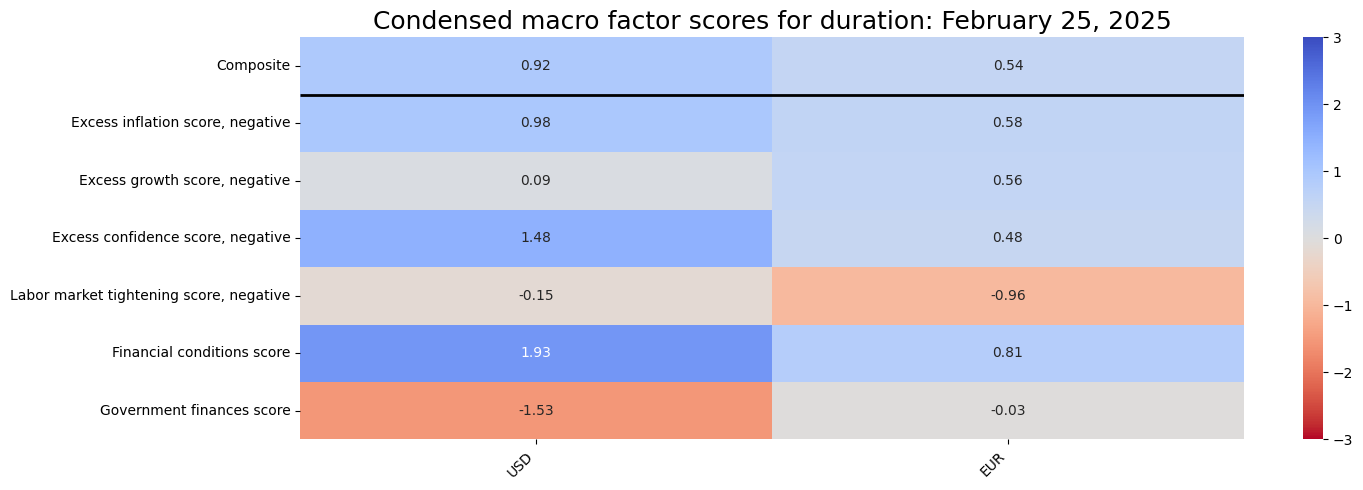

In [19]:
today = date.today().strftime("%B %d, %Y")

sv.view_snapshot(
    cids=cids_g2,
    transpose=True,
    title=f"Condensed macro factor scores for duration: {today}",
    title_fontsize=18,
    figsize=(15, 5),
    cmap_range = [-3, 3],
    xcats=list(dict_allz.keys()),
    xcat_labels=dict_allz,
)

In [20]:
a = sv.df[sv.df['xcat'] == 'Composite']
b = a[a['cid'] == 'USD']
b

,real_date,cid,xcat,value
82087,2000-02-01,USD,Composite,1.125437
82088,2000-02-02,USD,Composite,1.127583
82089,2000-02-03,USD,Composite,1.124487
82090,2000-02-04,USD,Composite,1.140731
82091,2000-02-07,USD,Composite,1.143350
...,...,...,...,...
88495,2024-08-23,USD,Composite,0.970794
88496,2024-08-26,USD,Composite,0.937008
88497,2024-08-27,USD,Composite,0.926255
88498,2024-08-28,USD,Composite,0.926078


In [21]:
sv.df.to_clipboard()

Latest day:  2024-08-29 00:00:00


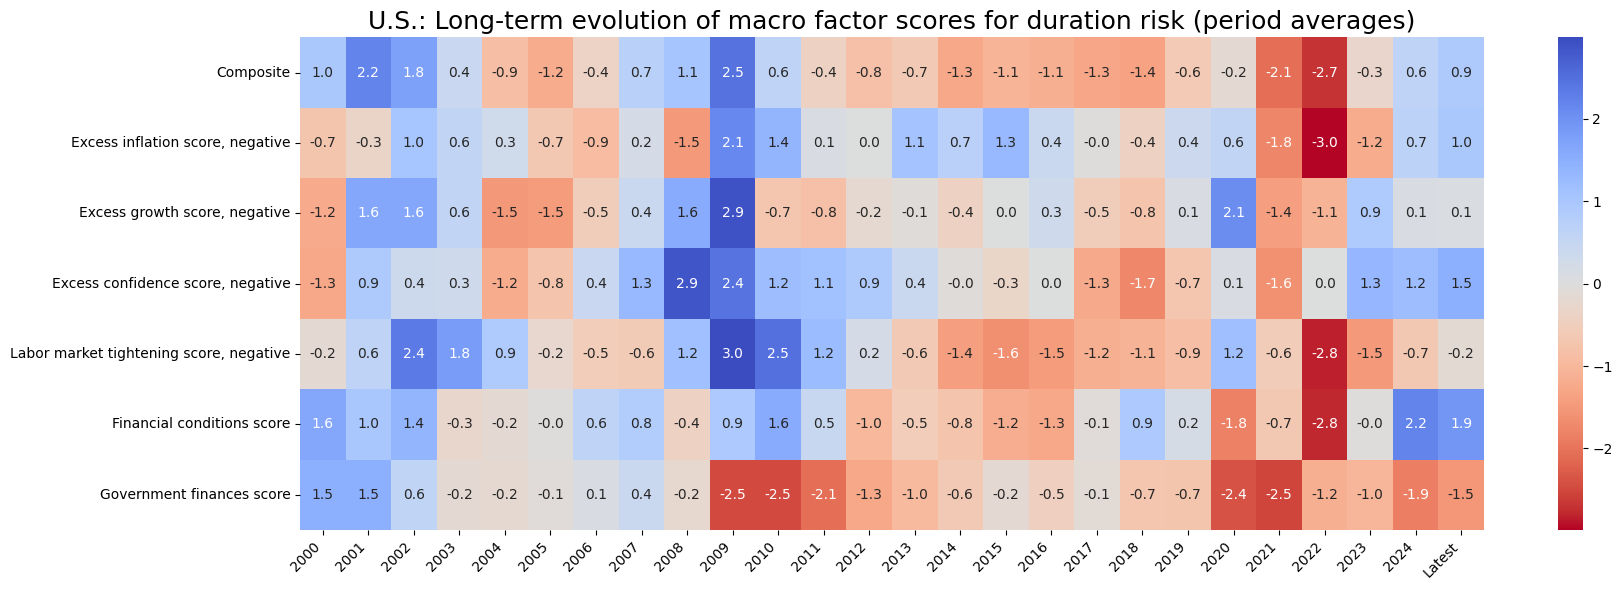

In [22]:
sv.view_cid_evolution(
    cid="USD",
    xcats=list(dict_allz.keys()),
    xcat_labels=dict_allz,
    freq="A",
    transpose=False,
    title="U.S.: Long-term evolution of macro factor scores for duration risk (period averages)",
    title_fontsize=18,
    figsize=(18, 6),
    round_decimals=1,
    start="2000-01-01",
)

Latest day:  2024-08-29 00:00:00


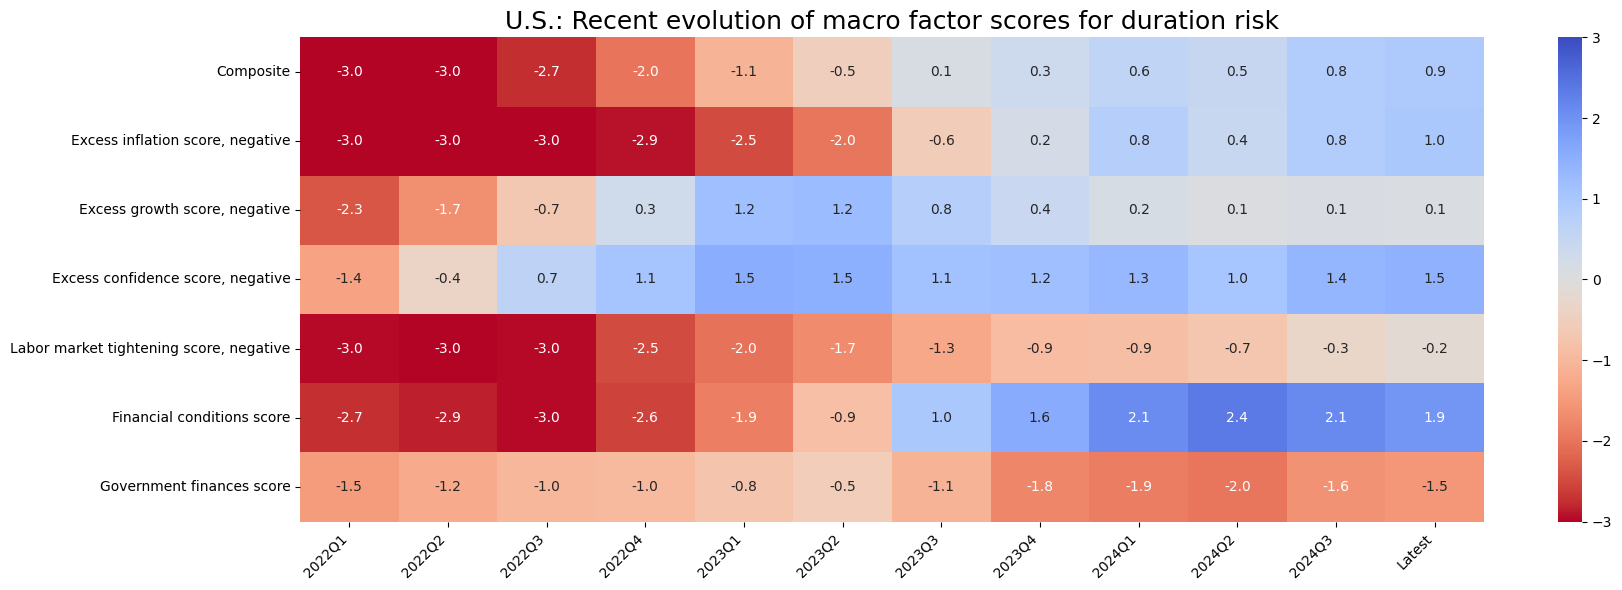

In [23]:
sv.view_cid_evolution(
    cid="USD",
    xcats=list(dict_allz.keys()),
    xcat_labels=dict_allz,
    freq="Q",
    transpose=False,
    title="U.S.: Recent evolution of macro factor scores for duration risk",
    title_fontsize=18,
    figsize=(18, 6),
    round_decimals=1,
    start="2022-01-01"
)

Latest day:  2024-08-29 00:00:00


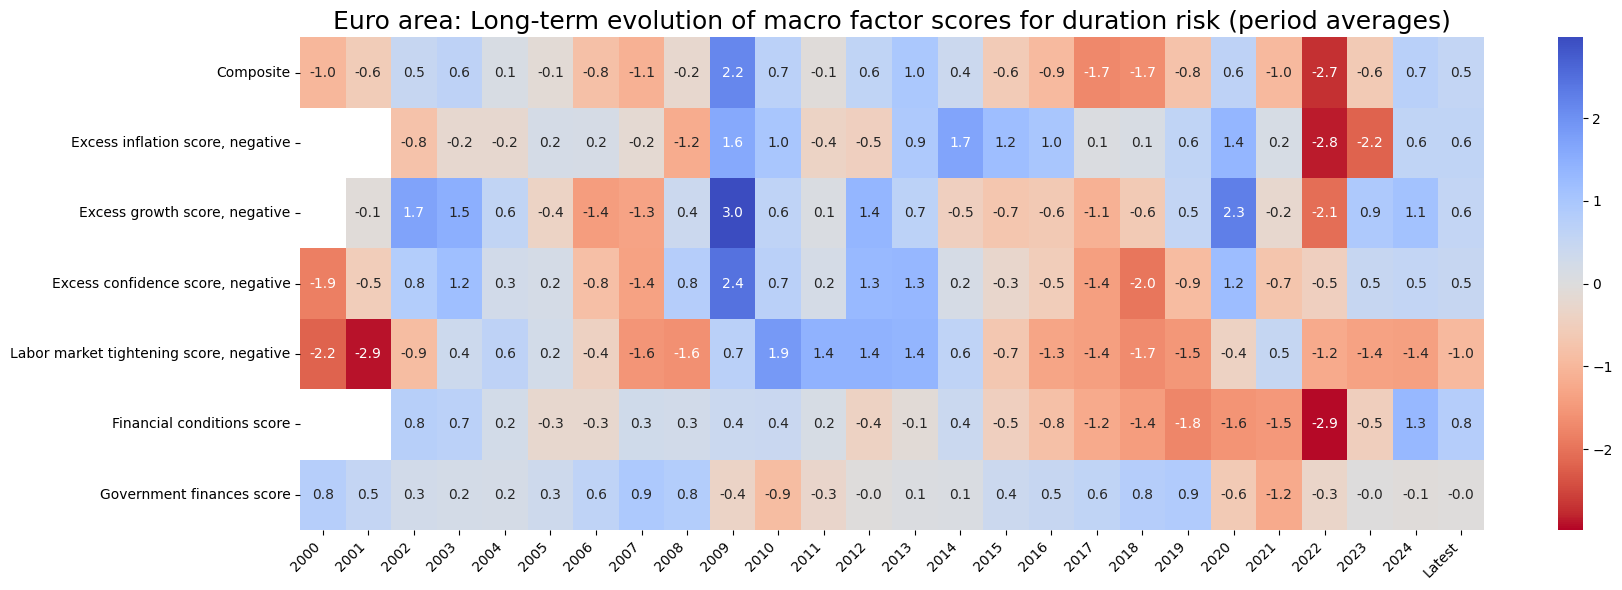

In [24]:
sv.view_cid_evolution(
    cid="EUR",
    xcats=list(dict_allz.keys()),
    xcat_labels=dict_allz,
    freq="A",
    transpose=False,
    title="Euro area: Long-term evolution of macro factor scores for duration risk (period averages)",
    title_fontsize=18,
    figsize=(18, 6),
    round_decimals=1,
    start="2000-01-01",
)

Latest day:  2024-08-29 00:00:00


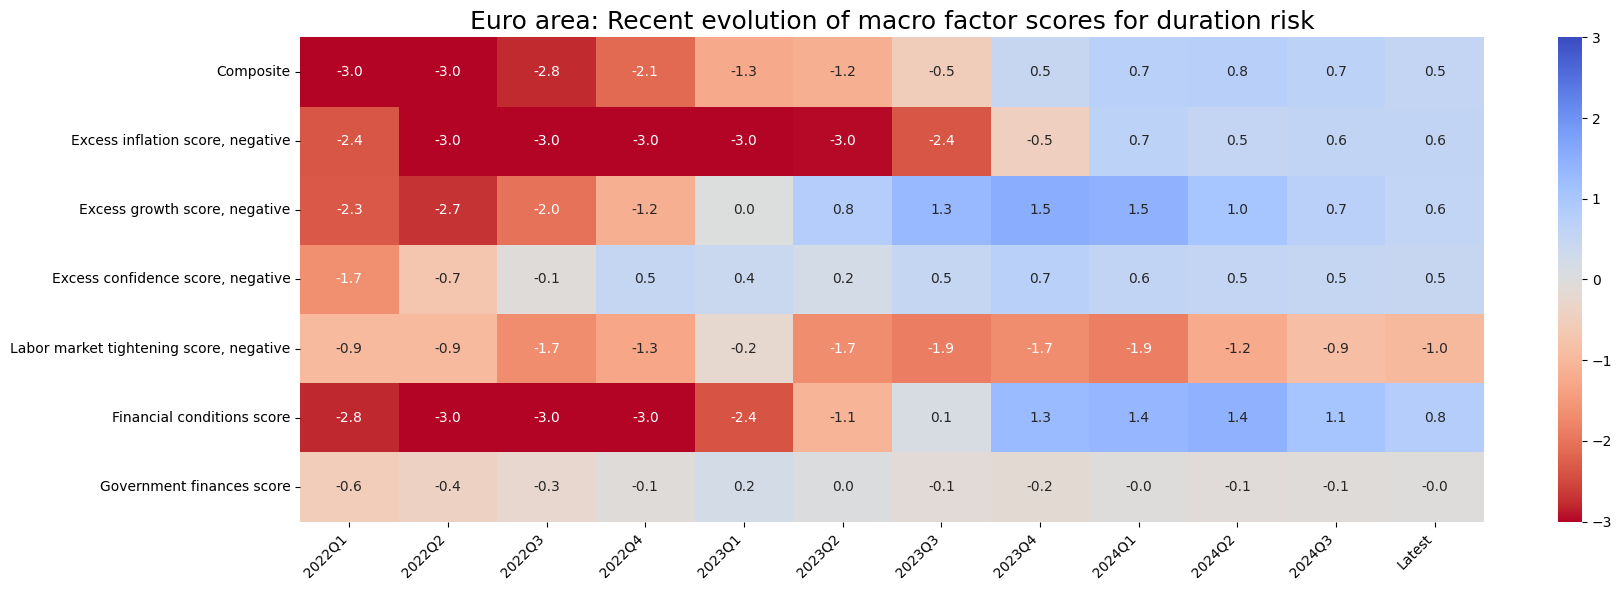

In [25]:
sv.view_cid_evolution(
    cid="EUR",
    xcats=list(dict_allz.keys()),
    xcat_labels=dict_allz,
    freq="Q",
    transpose=False,
    title="Euro area: Recent evolution of macro factor scores for duration risk",
    title_fontsize=18,
    figsize=(18, 6),
    round_decimals=1,
    start="2022-01-01",
)

In [26]:
dfa = sv.df[sv.df['xcat'] == 'Composite']
dfa = dfa.replace('Composite', 'COMPZG2')
dfx = msm.update_df(dfx, dfa)

### Indicator scores for the U.S.

In [27]:
sv_dict = {}
for key in dict_groups.keys():
    sv_dict[key] = ScoreVisualisers(
        dfx,
        cids=cids_g2,
        xcats=dict_groups[key],
        thresh=3,
        no_zn_scores=True,
        complete_xcats=False,
        rescore_composite = True
    )
    
dict_all_us_z = {**dict_groups, **{'Composite': 'Composite'}}

Latest day:  2024-08-29 00:00:00


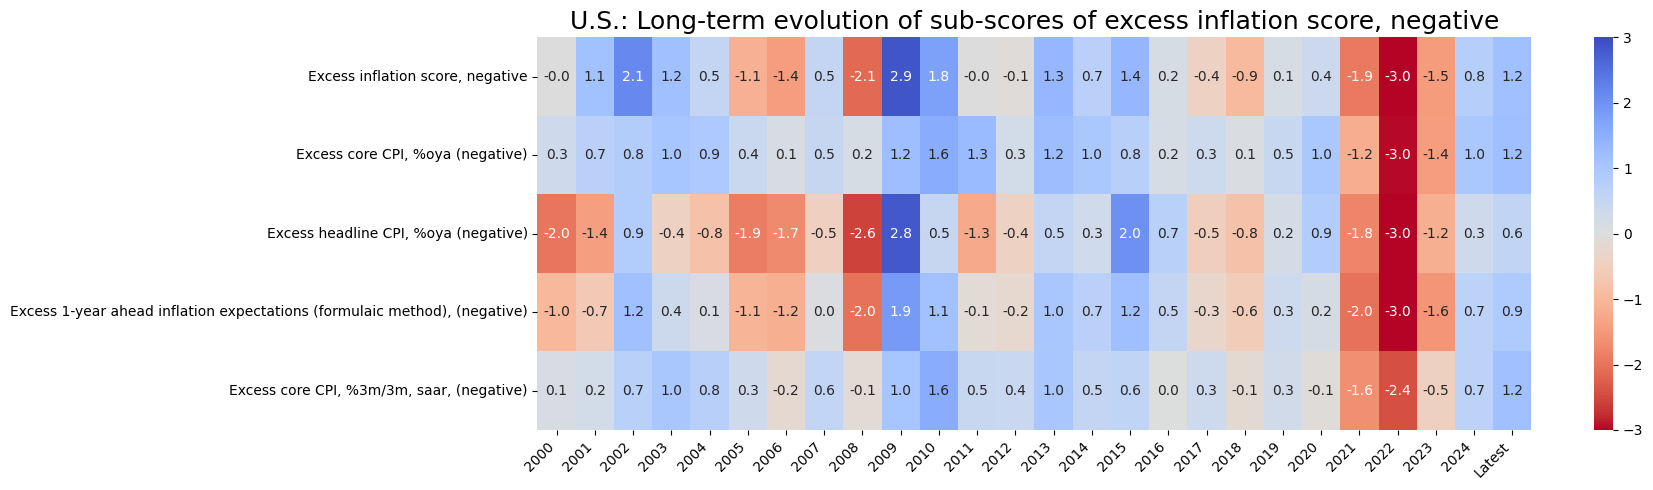

Latest day:  2024-08-29 00:00:00


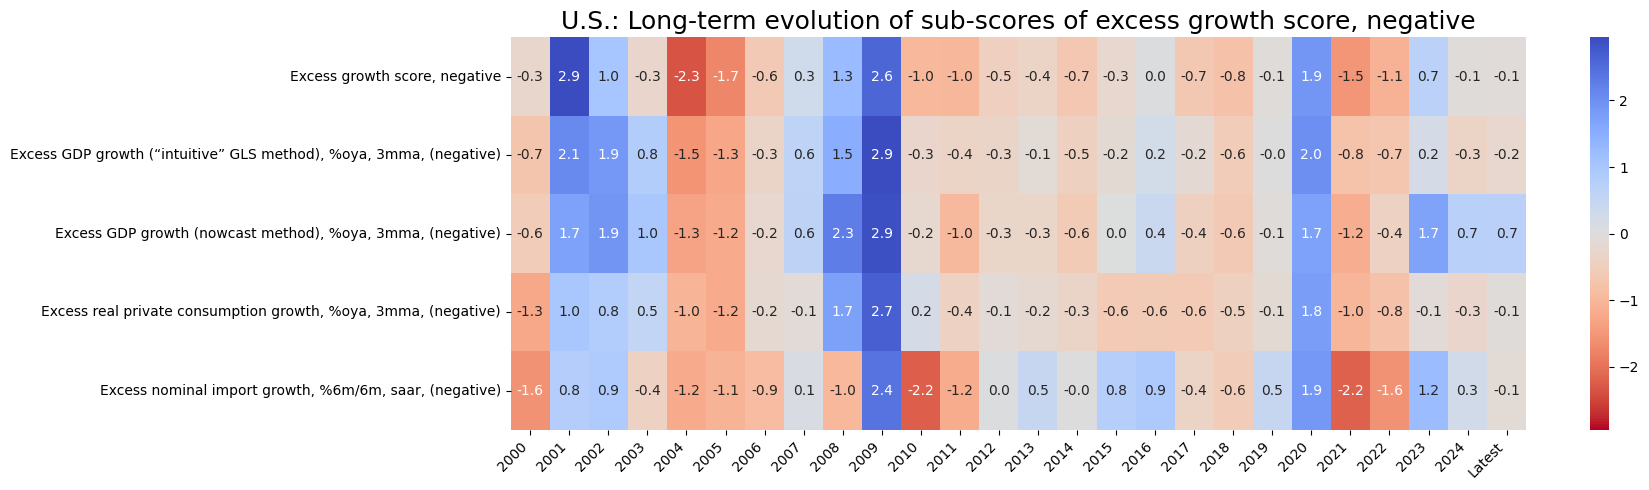

Latest day:  2024-08-29 00:00:00


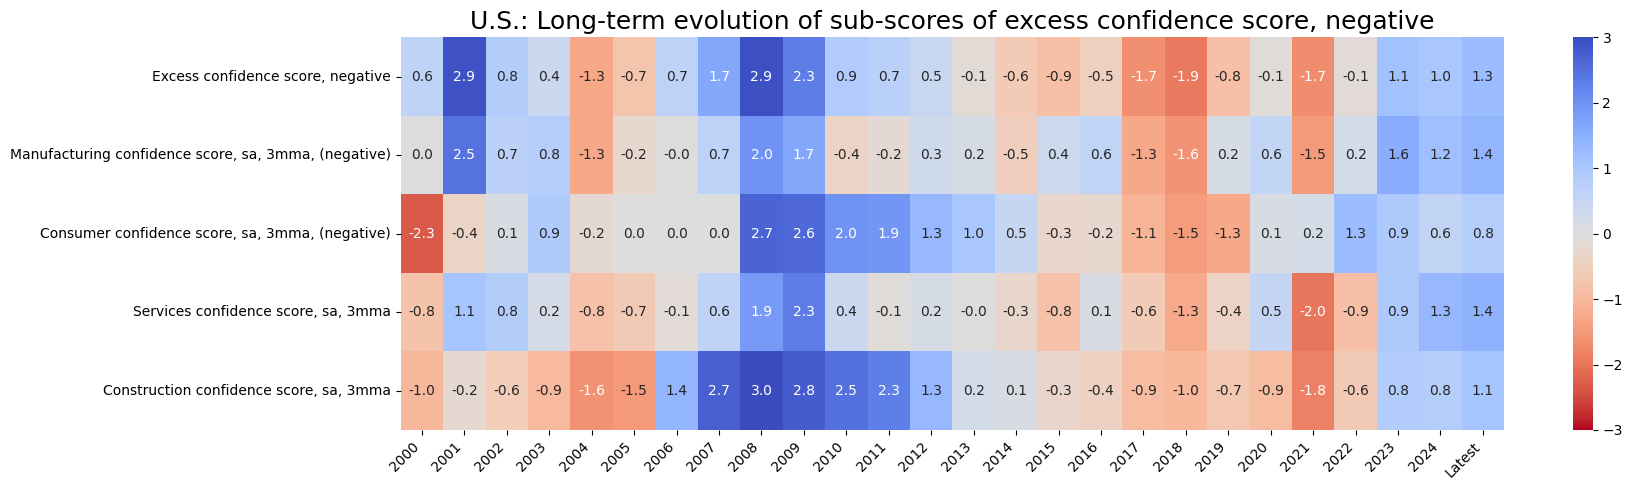

Latest day:  2024-08-29 00:00:00


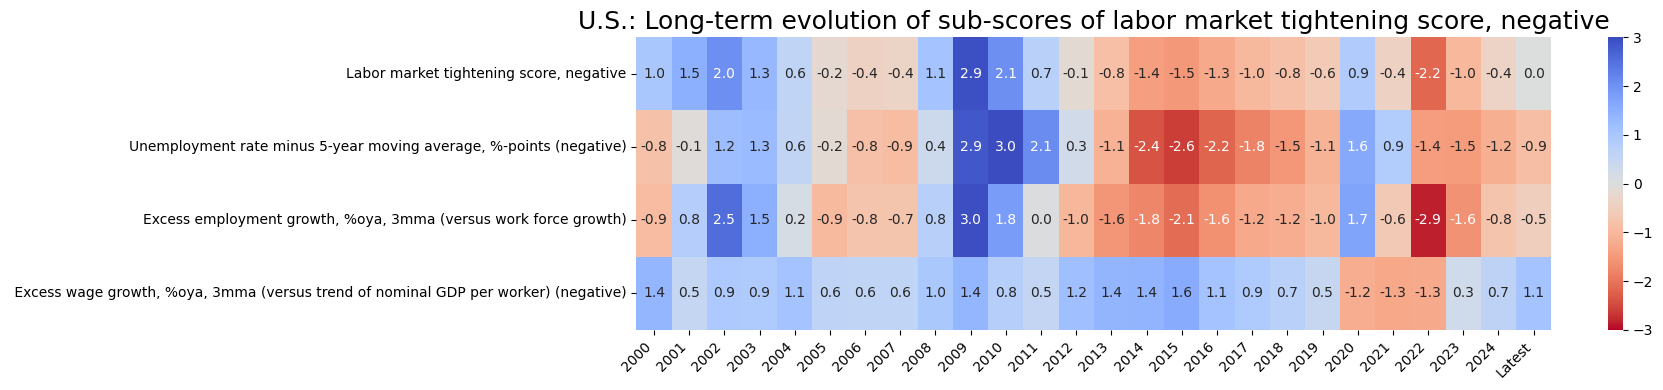

Latest day:  2024-08-29 00:00:00


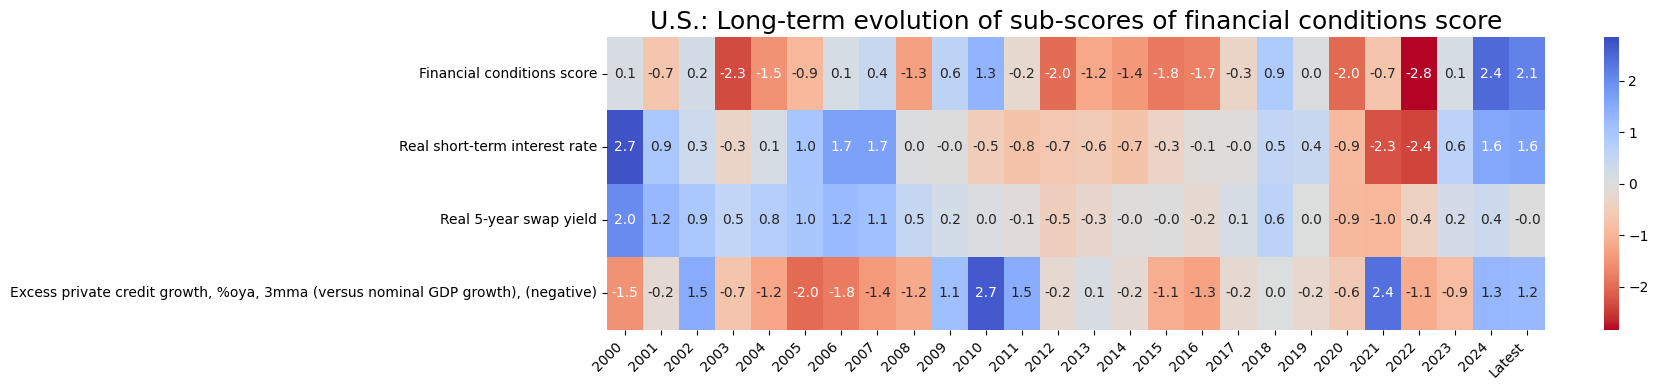

Latest day:  2024-08-29 00:00:00


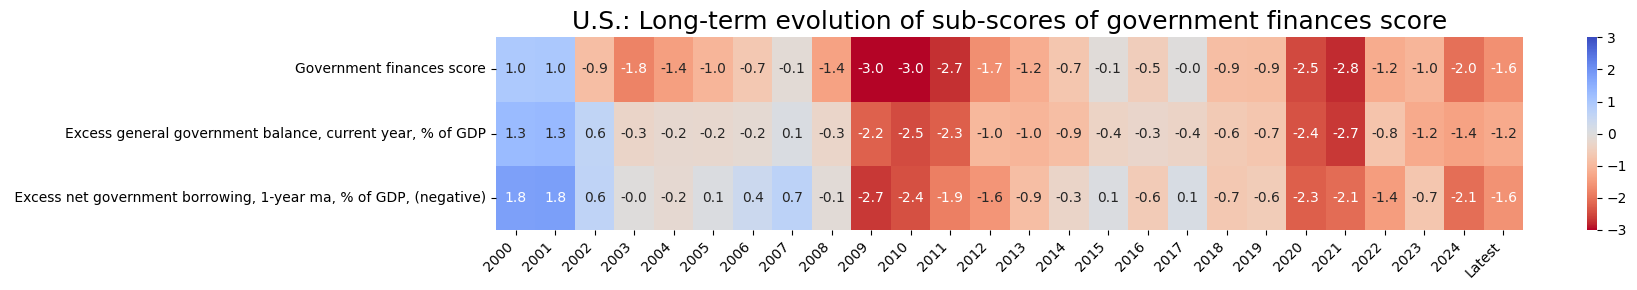

In [28]:
cid = 'USD'

for i in sv_dict:
    xcatx = list(dict_all_us_z[i]) + ["Composite"]
    dict_labs = {key: dict_labels[key] for key in dict_groups[i] if key in dict_labels}
    dict_labs["Composite"] = dict_groups_labels[i+'_ZN']
    sv_dict[i].view_cid_evolution(
        cid=cid,
        xcats= xcatx, 
        xcat_labels=dict_labs,
        freq="A",
        transpose=False,
        title=f"U.S.: Long-term evolution of sub-scores of {dict_groups_labels[i+'_ZN'].lower()}",
        title_fontsize=18,
        figsize=(18, len(xcatx)),
        round_decimals=1,
        start="2000-01-01",
    )

### Empirical validation

We proceed to study the relationships between the subscores and the returns from interest rate swaps (receiver positions). Theory would suggest there is a positive correlation between such variables.

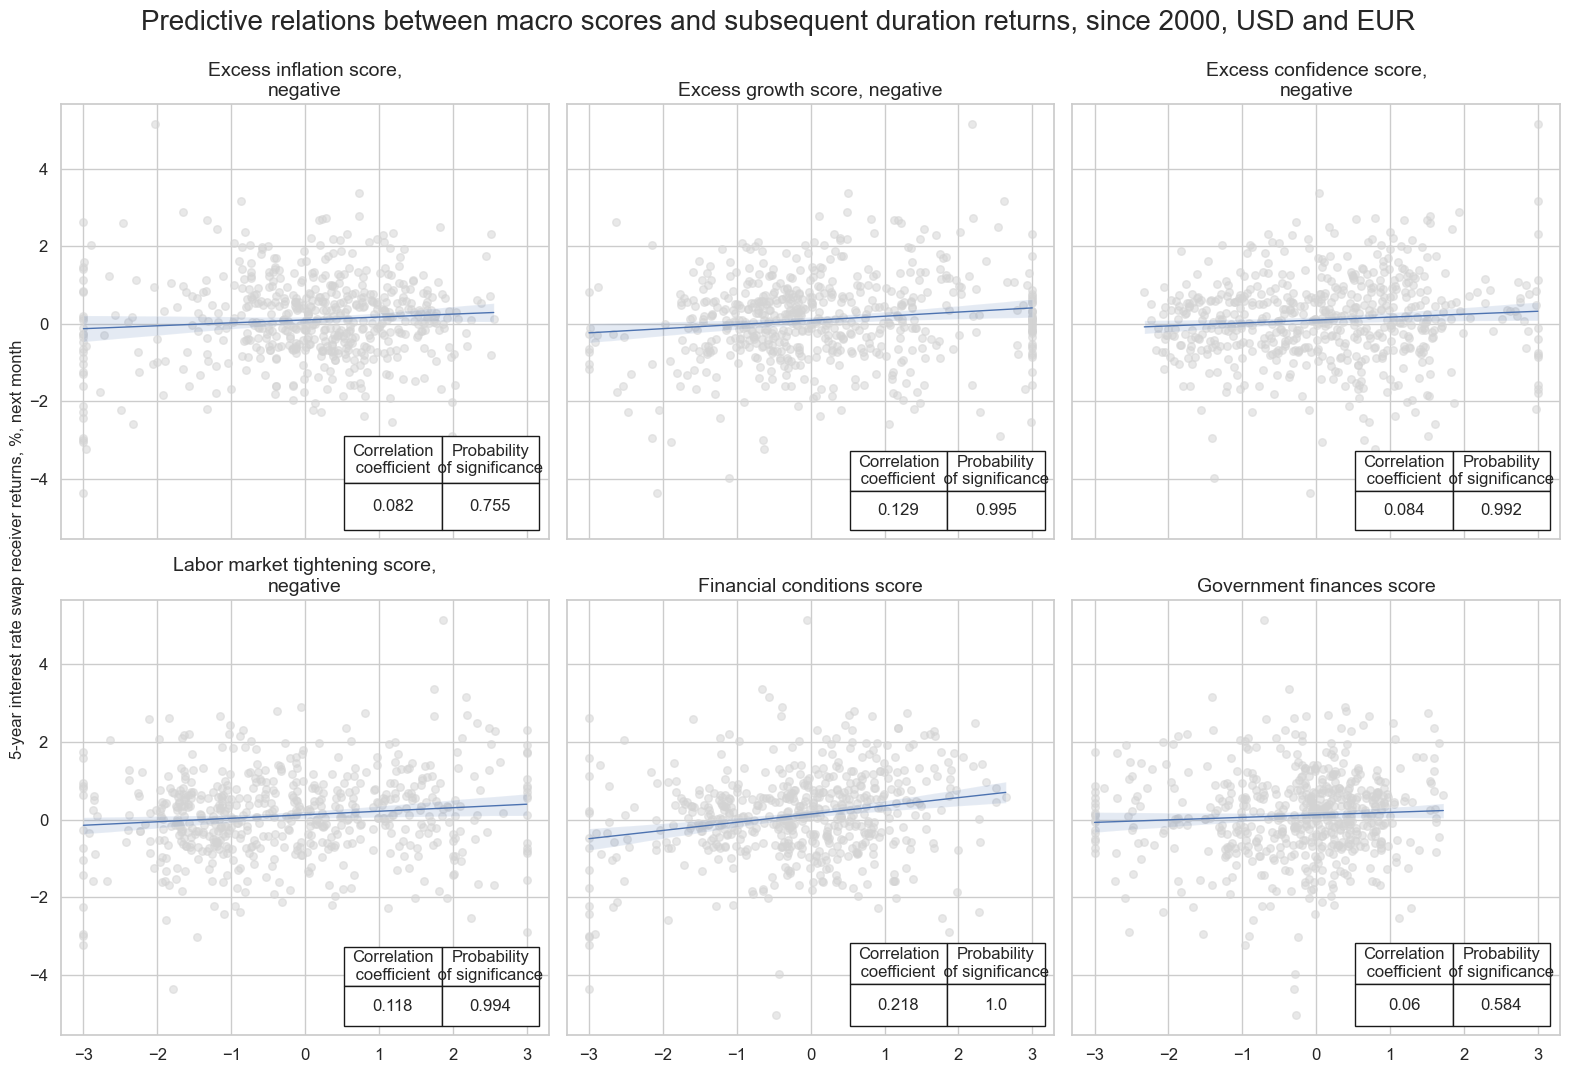

In [29]:
enr_dict = {
    "sigx": list(dict_groups_labels.keys()),
    "ret": "DU05YXR_NSA",
    "cidx": cids_g2,
    "freq": "M",
    "start": "2000-01-01",
    "black": None,
    "srr": None,
    "pnls": None,
}

dix = enr_dict

sigx = dix['sigx']
ret = dix['ret']
cidx = dix["cidx"]
freq = dix["freq"]
start = dix["start"]

catregs = {}
for sig in sigx:
    catregs[sig] = msp.CategoryRelations(
        dfx,
        xcats=[sig, ret],
        cids=cidx,
        freq=freq,
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
        # xcat_trims=[8, 8]  # maybe trim quarterly outlier
    )

msv.multiple_reg_scatter(
    cat_rels=[v for k, v in catregs.items()],
    ncol=3,
    nrow=2,
    figsize=(16, 11),
    title="Predictive relations between macro scores and subsequent duration returns, since 2000, USD and EUR",
    title_xadj=0.5,
    title_yadj=0.99,
    title_fontsize=20,
    xlab=None,
    ylab="5-year interest rate swap receiver returns, %, next month",
    coef_box="lower right",
    prob_est="map",
    single_chart=True,
    subplot_titles=[dict_groups_labels[key] for key in sigx],
)

The macro scores show positive and significant relationships with subsequent interest rate swap returns.

In [30]:
dict_g2 = {
    "sig": "COMPZG2",
    "target": "DU05YXR_NSA",
    "cidx": cids_g2,
    "start": "2000-01-01"
}

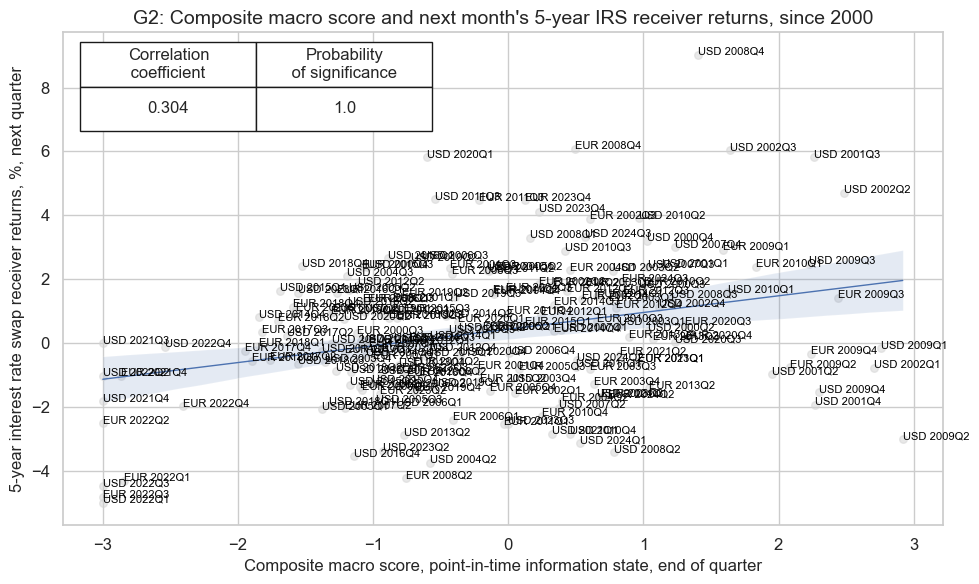

In [31]:
dix = dict_g2

sig = dix["sig"]
targ = dix["target"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    slip=1,
    xcat_aggs=["last", "sum"],
    start=start,
)

crx.reg_scatter(
    labels=True,
    coef_box="upper left",
    xlab="Composite macro score, point-in-time information state, end of quarter",
    ylab="5-year interest rate swap receiver returns, %, next quarter",
    title="G2: Composite macro score and next month's 5-year IRS receiver returns, since 2000",
    size=(10, 6),
    prob_est="map",
)

The composite macro score is strongly and significantly correlated with interest rate swap returns. This is expected and proves the nature and power of the macro composite in forecasting subsequent returns.

## Global thematic scores

We create thematic scores from the the macro support scores, using as weights the respective share in world GDP (USD terms) . The linear_composite() function creates a new cross-section with postfix GLB for “global”. We display the global weighted scores on a timeline.

In [32]:
cidx = cids_dm
dfa = pd.DataFrame(columns=list(dfx.columns))
weights = "USDGDPWGT_SA_3YMA"

for i in dict_groups.keys():
    dfa = msp.linear_composite(
            df=dfx,
            xcats=i,
            cids=cidx,
            weights=weights,
            complete_xcats=False,
            complete_cids=False,
            new_cid='GLB',
        )
    dfx = msm.update_df(dfx, dfa)


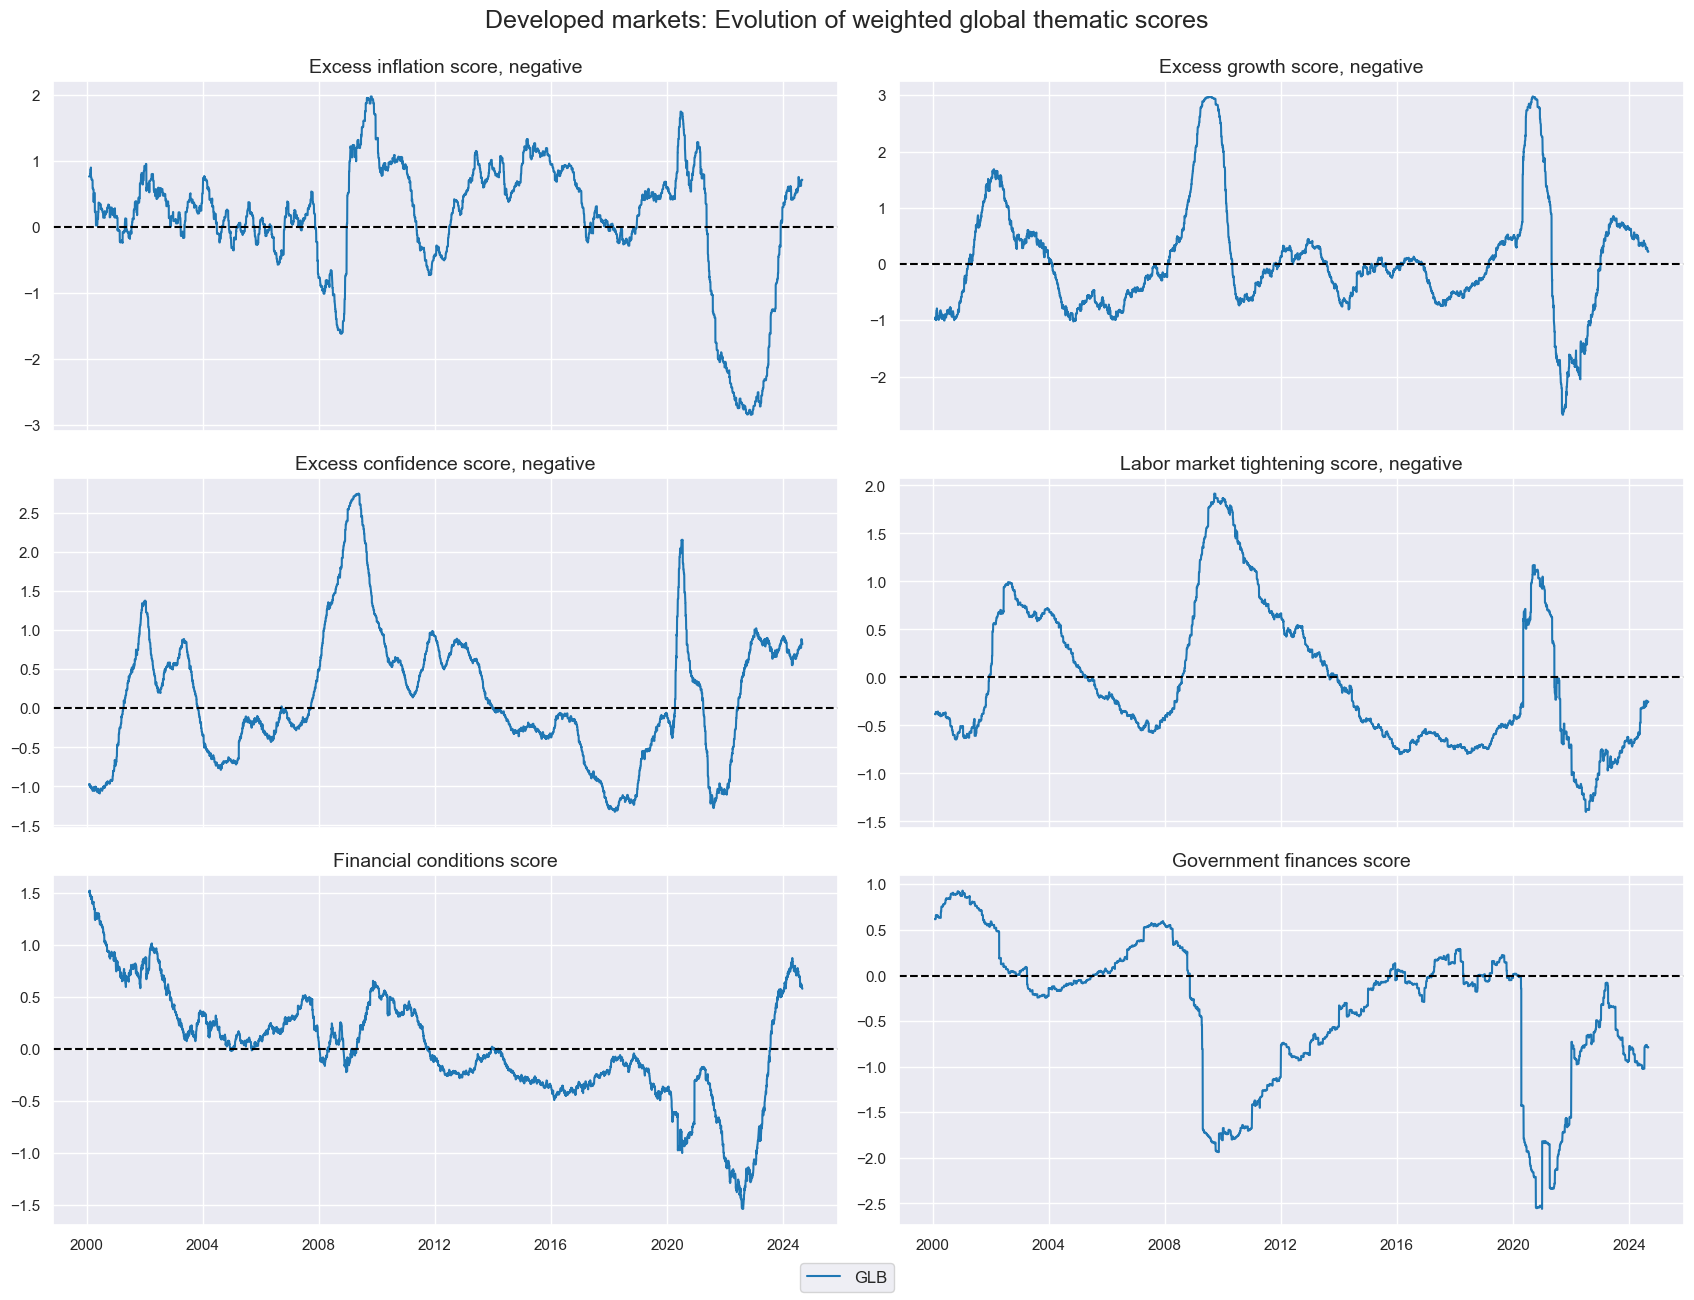

In [33]:
msp.view_timelines(
    dfx,
    xcats=list(dict_groups.keys()),
    cids='GLB',
    ncol=2,
    start="2000-01-01",
    xcat_grid=True,
    title="Developed markets: Evolution of weighted global thematic scores",
    same_y=False,
    xcat_labels=[dict_groups_labels[key] for key in list(dict_groups_labels.keys())],
    aspect=2,
)

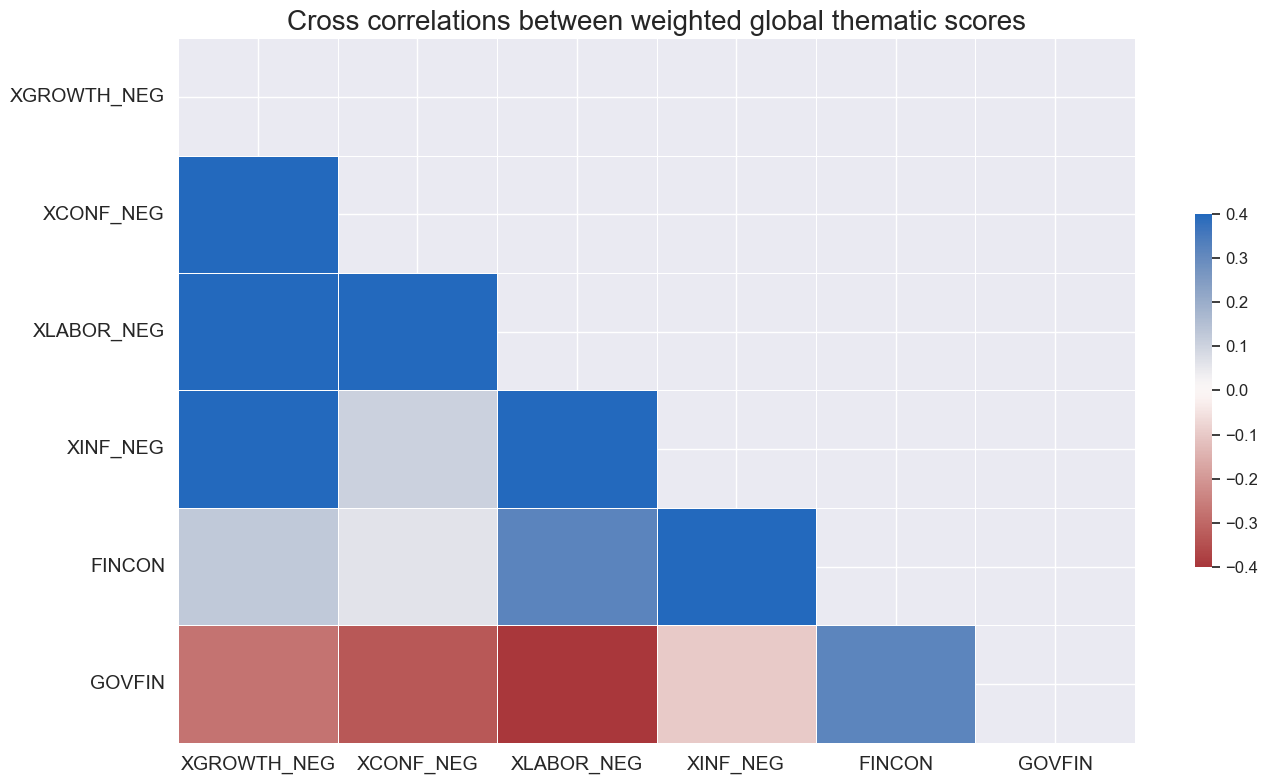

In [34]:
msp.correl_matrix(
    dfx,
    xcats=list(dict_groups.keys()),
    #xcats_secondary=rets, 
    cids='GLB',
    freq="W",
    #lags=[1,1],
    start="2000-01-01",
    max_color=0.4,
    cluster=True,
    title='Cross correlations between weighted global thematic scores'
)

Global thematic macro scores show similar pattern: a positive correlation among each other. The government finance indicator is the only indicator which shows a negative relationship with the other components. In particular, we see a strong increase in the scores after the global pandemic in 2020, followed by a decrease in the scores in 2021 and 2022, warranting a negative period for fixed income, following the global hiking path of central banks.

## Global scorecards and empirical validation

We build a version of the above scorecards which is built upon a larger group of cross sections, including developed markets Australia, Canada, Switzerland, UK, Japan and Sweden.

### Scorecards

In [35]:
svg = ScoreVisualisers(
    dfx,
    cids=cids_dm,
    xcats=list(dict_groups_labels.keys()),
    thresh=3,
    no_zn_scores=True,
    complete_xcats=False,
    rescore_composite = True
)
dict_all_g_z = {**dict_groups_labels, **{'Composite': 'Composite'}}

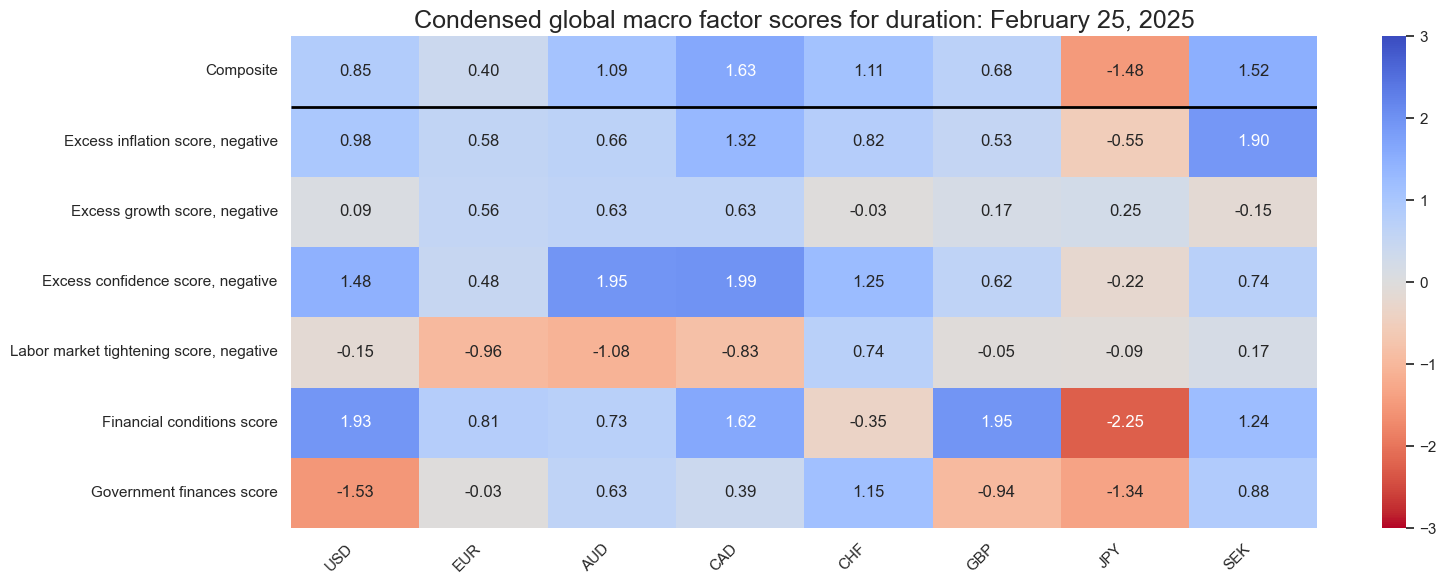

In [36]:
today = date.today().strftime("%B %d, %Y")

svg.view_snapshot(
    cids=cids_dm,
    transpose=True,
    title=f"Condensed global macro factor scores for duration: {today}",
    title_fontsize=18,
    figsize=(16, 6),
    cmap_range = [-3, 3],
    xcats=list(dict_all_g_z.keys()),
    xcat_labels=dict_all_g_z,
)

Latest day:  2024-08-29 00:00:00


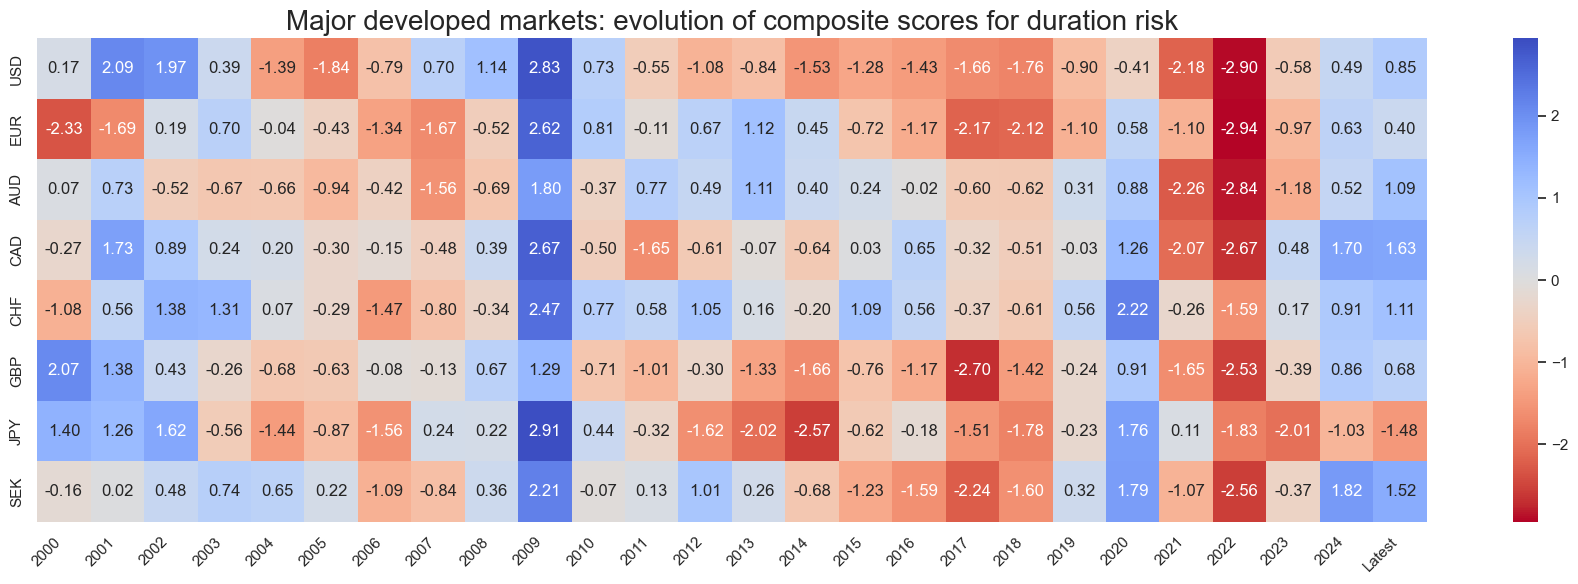

In [37]:
cidx = cids_dm

svg.view_score_evolution(
    xcat="Composite",
    cids=cidx,
    freq="A",
    transpose=False,
    title="Major developed markets: evolution of composite scores for duration risk",
    start="2000-01-01",
    figsize=(18, 6),
)

### Empirical validation

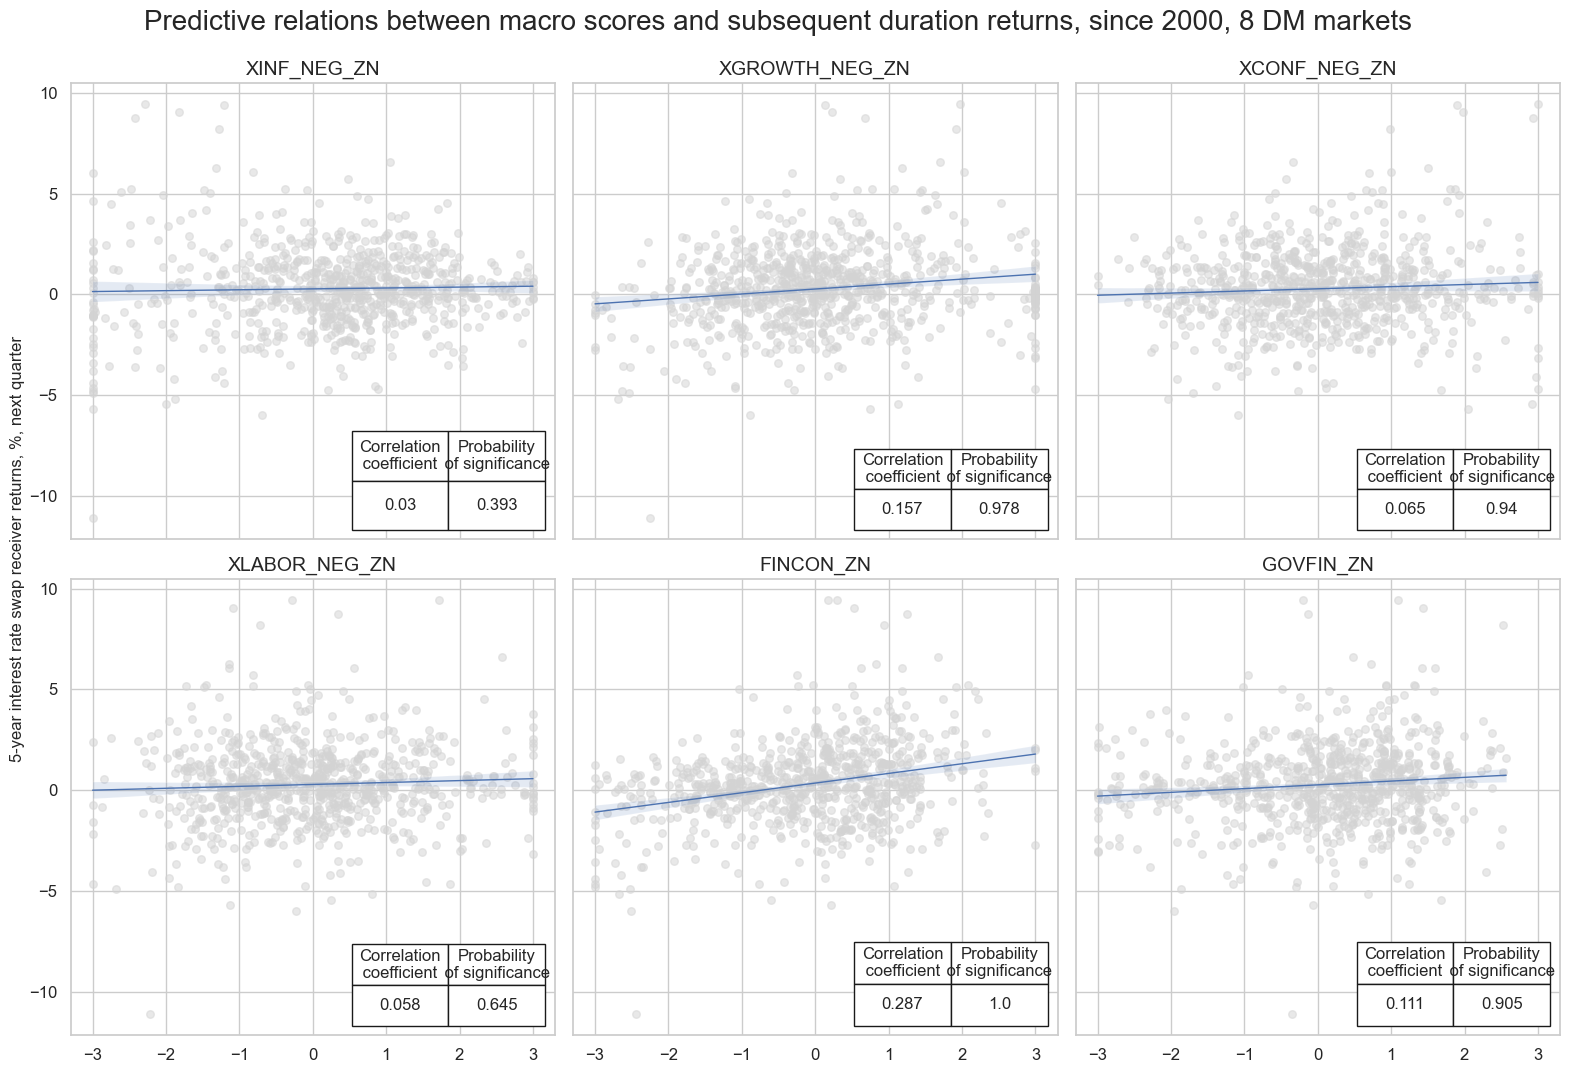

In [38]:
glb_dict = {
    "sigx": list(dict_groups_labels.keys()),
    "ret": "DU05YXR_NSA",
    "cidx": cids_dm,
    "freq": "Q",
    "start": "2000-01-01",
    "black": None,
    "srr": None,
    "pnls": None,
}

dix = glb_dict

sigx = dix['sigx']
ret = dix['ret']
cidx = dix["cidx"]
freq = dix["freq"]
start = dix["start"]

catregs = {}
for sig in sigx:
    catregs[sig] = msp.CategoryRelations(
        dfx,
        xcats=[sig, ret],
        cids=cidx,
        freq=freq,
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
    )

msv.multiple_reg_scatter(
    cat_rels=[v for k, v in catregs.items()],
    ncol=3,
    nrow=2,
    figsize=(16, 11),
    title="Predictive relations between macro scores and subsequent duration returns, since 2000, 8 DM markets",
    title_xadj=0.5,
    title_yadj=0.99,
    title_fontsize=20,
    xlab=None,
    ylab="5-year interest rate swap receiver returns, %, next quarter",
    coef_box="lower right",
    prob_est="map",
    single_chart=True,
    subplot_titles=sigx,
)

The sub-scores relative to the 8 developed markets are also positively and significantly correlated with subsequent IRS returns.

In [39]:
dfa = svg.df[svg.df['xcat'] == 'Composite']
dfa = dfa.replace('Composite', 'COMPZDM')

dfx = msm.update_df(dfx, dfa)

In [40]:
dict_glb = {
    "sig": "COMPZDM",
    "target": "DU05YXR_NSA",
    "cidx": cids_dm,
    "start": "2000-01-01"
}

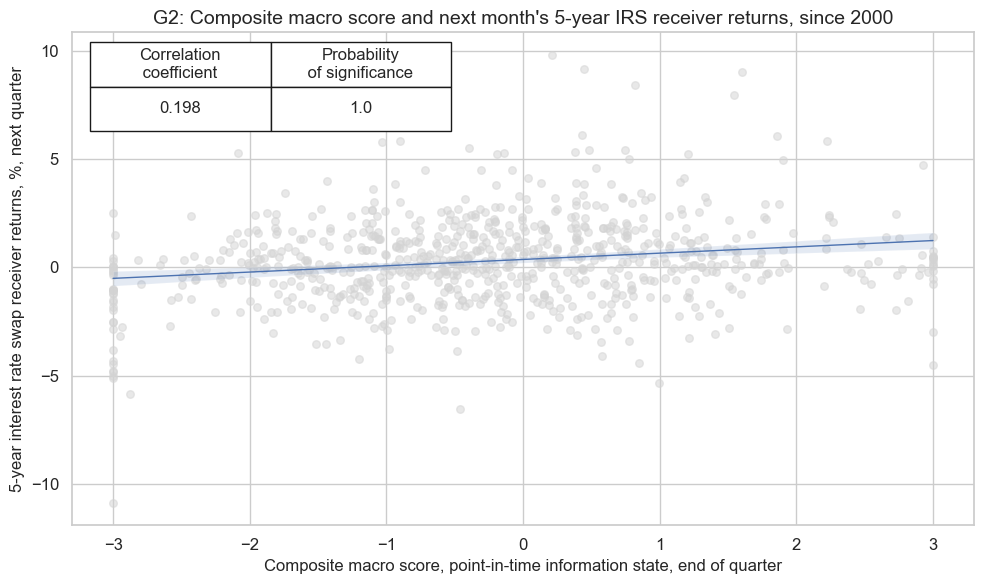

In [41]:
dix = dict_glb

sig = dix["sig"]
targ = dix["target"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    slip=1,
    xcat_aggs=["last", "sum"],
    start=start,
)

crx.reg_scatter(
    labels=False,
    coef_box="upper left",
    xlab="Composite macro score, point-in-time information state, end of quarter",
    ylab="5-year interest rate swap receiver returns, %, next quarter",
    title="G2: Composite macro score and next month's 5-year IRS receiver returns, since 2000",
    size=(10, 6),
    prob_est="map",
)

The composite score for developed markets is also, albeit slightly less, correlated with subsequent interest rate swap returns.

### Naive PnL analysis

In [42]:
sigs = ['COMPZG2']
sig = sigs[0]
naive_pnl = msn.NaivePnL(
    dfx,
    ret="DU05YXR_NSA",
    sigs=sigs,
    cids=cids_g2,
    start="2000-01-01",
    blacklist=None,
    bms=None,
)

In [43]:
naive_pnl.make_pnl(
        'COMPZG2',
        sig_neg=False,
        sig_op="zn_score_pan",
        rebal_freq="weekly",
        vol_scale=None,
        rebal_slip=1,
        thresh=2,
        pnl_name=sig + "_PNL",
    )

The value generated by simply allocating fixed-income risk according to the macro score has been considerable and quite consistent across time, except for the 2010s. This is perhaps due to the distortions in capital markets created by the large amounts of quantitative easing the world experienced in those years.

The below shows an approximate PnL based on the standard normalized macro composite score across the two selected countries, the US and Europe. (for the periods when signals were available and the market was tradable) and monthly rebalancing of positions in accordance with signal values. Positions are changed on the first trading day of the month and are assumed to have been updated by the beginning of the second trading day. The PnL chart has been normalized to 10% annualized volatility. This PnL is “naïve” insofar as we do not consider transaction costs and standard risk-management tools.

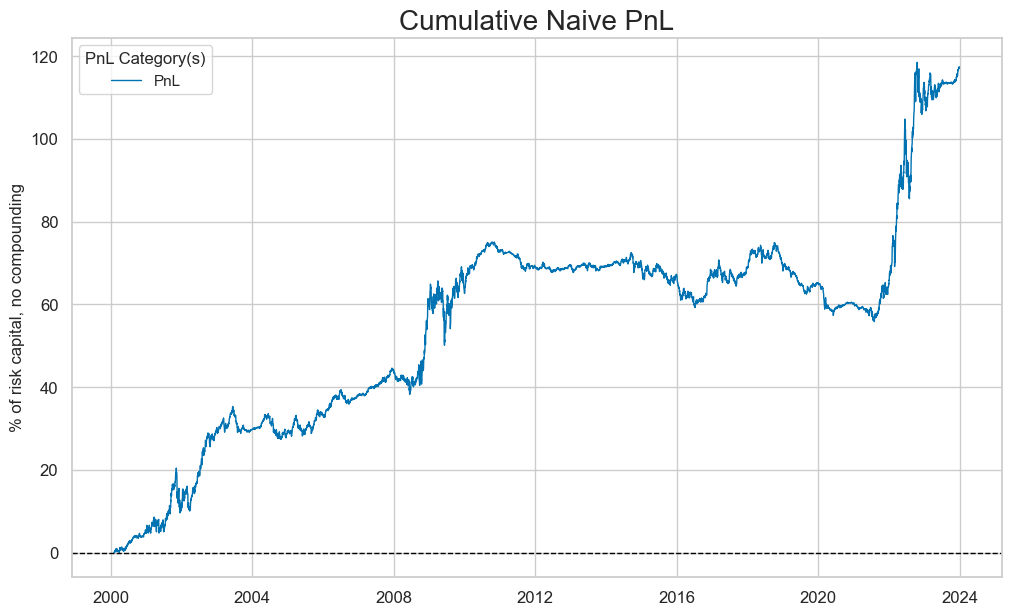

In [44]:
naive_pnl.plot_pnls(
    pnl_cats=["COMPZG2_PNL"],
    xcat_labels={"COMPZG2_PNL": 'PnL'},
    pnl_cids=["ALL"],
    start="2000-01-01",
    end="2023-12-31",
)


In [45]:
naive_pnl.evaluate_pnls(pnl_cats=naive_pnl.pnl_names)

xcat,COMPZG2_PNL
Return %,4.747743
St. Dev. %,7.78985
Sharpe Ratio,0.609478
Sortino Ratio,0.876474
Max 21-Day Draw %,-12.840556
Max 6-Month Draw %,-9.776025
Peak to Trough Draw %,-19.255041
Top 5% Monthly PnL Share,0.922148
Traded Months,295


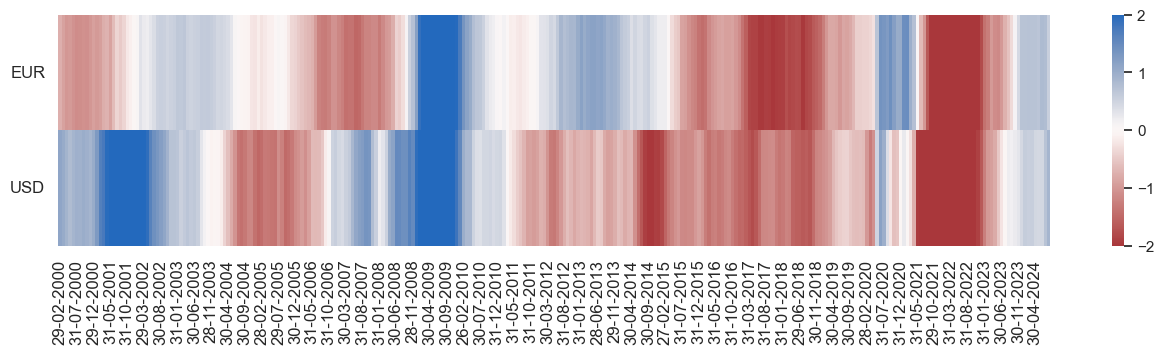

In [46]:
sig = ['COMPZG2_PNL']

naive_pnl.signal_heatmap(
    pnl_name=sig[0],
    freq="m",
    start="2000-01-01",
    figsize=(16, 3),
    title="",
)